In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [ ]:
train = pd.read_csv('/content/drive/My Drive/FINTECH Final/train.csv')
train2 = pd.read_csv('/content/drive/My Drive/FINTECH Final/dataset_2nd/public.csv')
test = pd.read_csv('/content/drive/My Drive/FINTECH Final/dataset_2nd/private_1_processed.csv')

In [ ]:
print(train.shape)
print(train2.shape)
print(test.shape)

(8688526, 26)
(609040, 26)
(754139, 25)


In [ ]:
test['label'] = -1
df = pd.concat([train, train2, test])
nan_count_per_column = df.isna().sum()

# Print the result
print("NaN count per column:")
print(nan_count_per_column)
print(df.shape)

NaN count per column:
txkey               0
locdt               0
loctm               0
chid                0
cano                0
contp               0
etymd          234320
mchno               0
acqic               0
mcc              5252
conam               0
ecfg                0
insfg               0
iterm               0
bnsfg               0
flam1               0
stocn             730
scity          307045
stscd        10024816
ovrlt               0
flbmk               0
hcefg          331844
csmcu          575619
csmam               0
flg_3dsmk           0
label               0
dtype: int64
(10051705, 26)


In [ ]:
# locdt 授權是在禮拜幾
df['weekday'] = df['locdt'] % 7
##loctm
df['loctm_hh'] = df['loctm'].apply(lambda x: math.floor(x/10000))
df['loctm_mm'] = df['loctm'].apply(lambda x: math.floor(x/100)-math.floor(x/10000)*100)
df['loctm_ss'] = df['loctm'].apply(lambda x: math.floor(x)-math.floor(x/100)*100)

In [ ]:
df['stscd'] = df['stscd'].map({0:False, 1:True})

In [ ]:
cat_cols = ['acqic','cano','chid','contp','csmcu','etymd',
            'hcefg',
            'mcc','mchno','scity','stocn','txkey']
bool_cols = ['ecfg','flbmk','flg_3dsmk','insfg','ovrlt','bnsfg']
num_cols = ['conam','csmam','flam1','iterm','locdt','loctm','weekday','loctm_hh','loctm_mm','loctm_ss']
df['ecfg'] = df['ecfg'].map({0:False, 1:True})
df['flbmk'] = df['flbmk'].map({0:False, 1:True})
df['flg_3dsmk'] = df['flg_3dsmk'].map({0:False, 1:True})
df['insfg'] = df['insfg'].map({0:False, 1:True})
df['ovrlt'] = df['ovrlt'].map({0:False, 1:True})
df['bnsfg'] = df['bnsfg'].map({0:False, 1:True})
df['label'] = df['label'].map({0:False, 1:True})

df[cat_cols] = df[cat_cols].astype('object')
df.dtypes

txkey         object
locdt          int64
loctm          int64
chid          object
cano          object
contp         object
etymd         object
mchno         object
acqic         object
mcc           object
conam        float64
ecfg            bool
insfg           bool
iterm        float64
bnsfg           bool
flam1          int64
stocn         object
scity         object
stscd         object
ovrlt           bool
flbmk           bool
hcefg         object
csmcu         object
csmam          int64
flg_3dsmk       bool
label         object
weekday        int64
loctm_hh       int64
loctm_mm       int64
loctm_ss       int64
dtype: object

# 是否為海外消費

<Axes: xlabel='stocn', ylabel='count'>

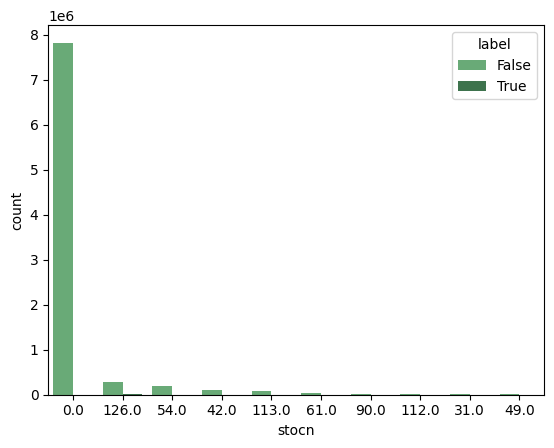

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="stocn", hue="label", data=df[df.label!=-1], palette="Greens_d",
              order=pd.value_counts(df[df.label!=-1]['stocn']).iloc[:10].index)


In [ ]:
df["oversea_flag"] = df.stocn != 0

In [ ]:
# change to percentage
oversea_pct = df.loc[:,['cano','oversea_flag']][df.label!=-1].groupby('cano').mean()

In [ ]:
# clustering by k-means with elbow method
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(oversea_pct)
#   oversea_pct["clusters"] = kmeans.labels_
#   print(oversea_pct["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
##k = 要找K帶入n_cluseters
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(oversea_pct)
oversea_pct["oversea_clusters"] = kmeans.labels_
oversea_pct.head(20)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,oversea_flag,oversea_clusters
cano,,
000004e90549c10a46912120949a36bbe9c92fb02daa27703f232957db971a3e,0.000000,0
00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9827c2fbb8783119da4,0.000000,0
0000635e95f06e3542a664112f7dc9610e11ca4de383b1eb72679534e28dabe4,0.000000,0
000085a95392a936a8f34bdaa9d05f7df0a6c2225cb776895e36dfe1194f52fd,0.000000,0
0000d1a82b1e29f7902725efd722923c726b5d826d6df3ea75e717a921d68e96,0.000000,0
0000e2fbf64f4865fe66e20a0a63f94af5abc43807123e1781037bc13812b306,0.000000,0
0000fd2e52c5ec225c8114313caae6982e5957d789d6e3a0c935702231904cd7,0.000000,0
0001068bc5c324226b191cbb93d310488c0775facae66b5a36600cb6847edcc3,0.000000,0
00010bf5a87771976d5839f07e4cb09d7b074705bcd9b014aaee619544317c7b,0.000000,0


In [ ]:
df.head(5)

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,hcefg,csmcu,csmam,flg_3dsmk,label,weekday,loctm_hh,loctm_mm,loctm_ss,oversea_flag
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,6.0,70.0,1529,False,False,4,10,18,12,False
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,8.0,70.0,101,False,False,3,8,55,9,False
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,6.0,70.0,116,False,False,2,21,26,41,False
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,6.0,70.0,1683,False,False,0,10,27,2,False
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,6.0,70.0,14,False,False,3,18,57,37,False


In [ ]:
# Merge DataFrames on 'cano' column and update 'flag' in df based on df2
df = pd.merge(df, oversea_pct, on='cano', how='left', suffixes=('', '_df2'))

# If you want to replace the original 'flag' column with the values from df2
df['oversea_flag'] = df['oversea_flag_df2']

# Drop unnecessary columns (if needed)
df = df.drop(columns=['oversea_flag_df2'])

# Display the updated DataFrame
df.head(5)


,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,csmcu,csmam,flg_3dsmk,label,weekday,loctm_hh,loctm_mm,loctm_ss,oversea_flag,oversea_clusters
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,70.0,1529,False,False,4,10,18,12,0.121622,0
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,70.0,101,False,False,3,8,55,9,0.142857,0
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,70.0,116,False,False,2,21,26,41,0.000000,0
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,70.0,1683,False,False,0,10,27,2,0.000000,0
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,70.0,14,False,False,3,18,57,37,0.078125,0


# 是否為網路消費


In [ ]:
# change to percentage
ecfg_pct = df.loc[:,['cano','ecfg']][df.label!=-1].groupby('cano').mean()

In [ ]:
# clustering by k-means with elbow method
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(ecfg_pct)
#   oversea_pct["clusters"] = kmeans.labels_
#   print(oversea_pct["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
##k = 2
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(ecfg_pct)
ecfg_pct["ecfg_clusters"] = kmeans.labels_
ecfg_pct.head(20)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,ecfg,ecfg_clusters
cano,,
000004e90549c10a46912120949a36bbe9c92fb02daa27703f232957db971a3e,0.000000,1
00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9827c2fbb8783119da4,1.000000,0
0000635e95f06e3542a664112f7dc9610e11ca4de383b1eb72679534e28dabe4,0.866667,0
000085a95392a936a8f34bdaa9d05f7df0a6c2225cb776895e36dfe1194f52fd,0.000000,1
0000d1a82b1e29f7902725efd722923c726b5d826d6df3ea75e717a921d68e96,0.000000,1
0000e2fbf64f4865fe66e20a0a63f94af5abc43807123e1781037bc13812b306,1.000000,0
0000fd2e52c5ec225c8114313caae6982e5957d789d6e3a0c935702231904cd7,0.400000,1
0001068bc5c324226b191cbb93d310488c0775facae66b5a36600cb6847edcc3,0.000000,1
00010bf5a87771976d5839f07e4cb09d7b074705bcd9b014aaee619544317c7b,0.000000,1


In [ ]:
# Merge DataFrames on 'cano' column and update 'flag' in df based on df2
df = pd.merge(df, ecfg_pct, on='cano', how='left', suffixes=('', '_df2'))

# If you want to replace the original 'flag' column with the values from df2
df['ecfg'] = df['ecfg_df2']

# Drop unnecessary columns (if needed)
df = df.drop(columns=['ecfg_df2'])
df.head(5)

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,csmam,flg_3dsmk,label,weekday,loctm_hh,loctm_mm,loctm_ss,oversea_flag,oversea_clusters,ecfg_clusters
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,1529,False,False,4,10,18,12,0.121622,0,0
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,101,False,False,3,8,55,9,0.142857,0,0
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,116,False,False,2,21,26,41,0.000000,0,1
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,1683,False,False,0,10,27,2,0.000000,0,1
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,14,False,False,3,18,57,37,0.078125,0,0


# MCC消費種類數

In [ ]:
mcc_code = df.loc[:,['mcc', 'conam']].groupby(['mcc']).describe()
mcc_code.columns
mcc_code.columns = mcc_code.columns.droplevel()
mcc_code.fillna(0, inplace=True)
mcc_code.head(5)

,count,mean,std,min,25%,50%,75%,max
mcc,,,,,,,,
0.0,516.0,5841.644360,13704.166930,1.0,1050.00,2300.000,5310.000,191800.00
1.0,109.0,1293.175505,1545.021390,56.0,335.62,723.840,1700.000,9370.00
2.0,10.0,7733.441000,15196.682567,160.0,320.00,920.000,4072.715,48020.25
3.0,569.0,61567.771459,84400.754696,0.0,2031.59,40575.230,100000.000,890000.00
4.0,50.0,1692.094200,1602.386912,0.0,320.02,959.445,3200.210,7260.43


In [ ]:
mcc_code.columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

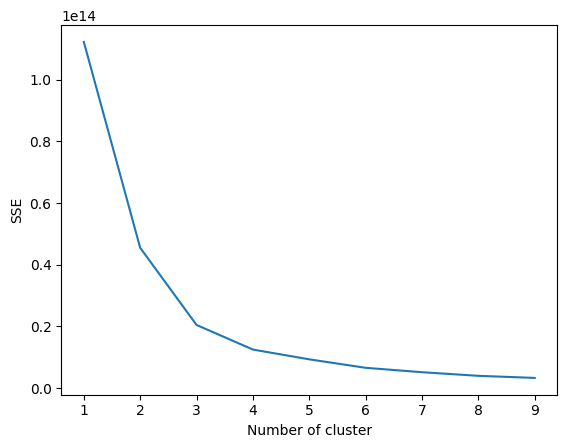

In [ ]:
# clustering by k-means with elbow method
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(mcc_code)
#   oversea_pct["clusters"] = kmeans.labels_
#   print(oversea_pct["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
# count mcc
mcc_txn_cnt = df.loc[:,['cano','mcc', 'conam']][df.label!=-1].groupby(['cano','mcc']).count()
mcc_cnt = df.loc[:,['cano','mcc', 'conam']][df.label!=-1].groupby(['cano','mcc']).count().groupby(['cano']).count()

In [ ]:
mcc_txn_cnt.groupby(['cano']).mean().head(5)

,conam
cano,
000004e90549c10a46912120949a36bbe9c92fb02daa27703f232957db971a3e,2.00
00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9827c2fbb8783119da4,2.50
0000635e95f06e3542a664112f7dc9610e11ca4de383b1eb72679534e28dabe4,3.75
000085a95392a936a8f34bdaa9d05f7df0a6c2225cb776895e36dfe1194f52fd,1.00
0000e2fbf64f4865fe66e20a0a63f94af5abc43807123e1781037bc13812b306,4.00


In [ ]:
mcc_pct = mcc_txn_cnt.groupby(['cano']).apply(lambda x:100 * x / float(x.sum())) #這個會跑比較久

<ipython-input-19-62157e31d0cd>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mcc_pct = mcc_txn_cnt.groupby(['cano']).apply(lambda x:100 * x / float(x.sum())) #這個會跑比較久


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

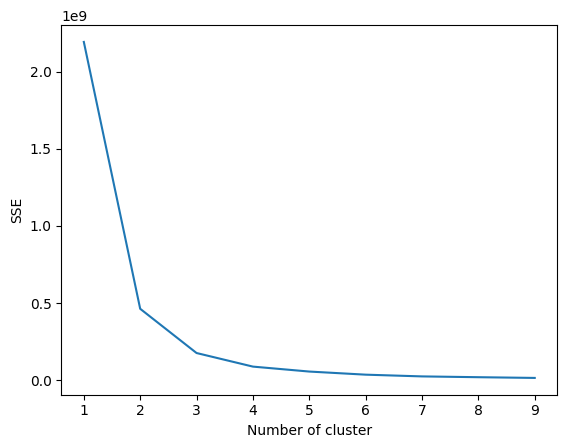

In [ ]:
# clustering by k-means with elbow method
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(mcc_pct)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
##k = 3
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(mcc_pct)
mcc_pct["mcc_pct_clusters"] = kmeans.labels_
mcc_pct

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


conam  \
cano                                               mcc                 
000004e90549c10a46912120949a36bbe9c92fb02daa277... 486.0  100.000000   
00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c98... 272.0   13.333333   
                                                   275.0   13.333333   
                                                   276.0   33.333333   
                                                   281.0   13.333333   
...                                                              ...   
ffff8fed185e7a8295d6081fcac3a78cdd72d08903b95c0... 379.0    4.166667   
                                                   466.0    8.333333   
ffffa5b23e42f7b181116352663f282cd5e2f94a0bf5b60... 275.0   33.333333   
                                                   276.0   33.333333   
                                                   288.0   33.333333   

                                                          mcc_pct_clusters  
cano                                               mcc                      
000004e90549c10a46912120949a36bbe9c92fb02daa277... 486.0                 2  
00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c98... 272.0                 1  
                                                   275.0                 1  
                                                   276.0                 0  
                                                   281.0                 1  
...                                                                    ...  
ffff8fed185e7a8295d6081fcac3a78cdd72d08903b95c0... 379.0                 1  
                                                   466.0                 1  
ffffa5b23e42f7b181116352663f282cd5e2f94a0bf5b60... 275.0                 0  
                                                   276.0                 0  
                                                   288.0                 0  

[2961550 rows x 2 columns]

In [ ]:
# Merge DataFrames on 'cano' column and update 'flag' in df based on df2
df = pd.merge(df, mcc_pct, on=['cano', 'mcc'], how='left', suffixes=('', '_percentage'))

df.head(5)

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,label,weekday,loctm_hh,loctm_mm,loctm_ss,oversea_flag,oversea_clusters,ecfg_clusters,conam_percentage,mcc_pct_clusters
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,False,4,10,18,12,0.121622,0,0,2.702703,1.0
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,False,3,8,55,9,0.142857,0,0,42.857143,0.0
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,False,2,21,26,41,0.000000,0,1,35.714286,0.0
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,False,0,10,27,2,0.000000,0,1,83.333333,2.0
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,False,3,18,57,37,0.078125,0,0,17.187500,1.0


In [ ]:
df.shape

(10051705, 35)

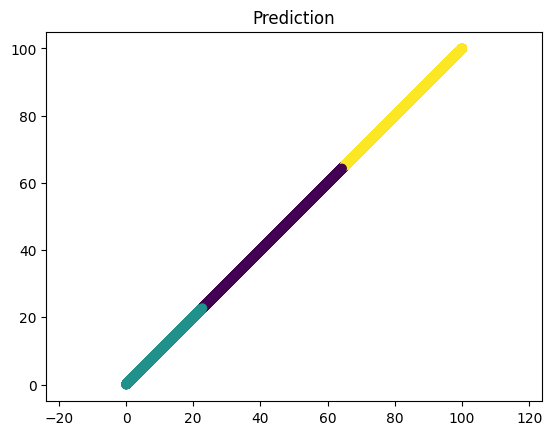

In [ ]:
#results visualization
plt.figure()
plt.scatter(mcc_pct['conam'], mcc_pct['conam'], c = mcc_pct['clusters'])
plt.axis('equal')
plt.title('Prediction')
plt.show()

In [ ]:
mcc_pct.groupby(['clusters']).describe()

In [ ]:
mcc_pct_sum = mcc_pct.groupby(['cano','clusters']).sum()

In [ ]:
mcc_pct_sum['rank'] = mcc_pct.groupby(['cano','clusters']).sum().groupby(['cano']).rank(ascending=False, method='max')

In [ ]:
mcc_pct_sum[mcc_pct_sum['rank']==1].head(20)

,,conam,rank
cano,clusters,,
000004e90549c10a46912120949a36bbe9c92fb02daa27703f232957db971a3e,2,100.000000,1.0
00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9827c2fbb8783119da4,1,71.428571,1.0
0000635e95f06e3542a664112f7dc9610e11ca4de383b1eb72679534e28dabe4,0,69.230769,1.0
000085a95392a936a8f34bdaa9d05f7df0a6c2225cb776895e36dfe1194f52fd,2,100.000000,1.0
0000e2fbf64f4865fe66e20a0a63f94af5abc43807123e1781037bc13812b306,2,100.000000,1.0
0000fd2e52c5ec225c8114313caae6982e5957d789d6e3a0c935702231904cd7,1,100.000000,1.0
0001068bc5c324226b191cbb93d310488c0775facae66b5a36600cb6847edcc3,2,100.000000,1.0
00010bf5a87771976d5839f07e4cb09d7b074705bcd9b014aaee619544317c7b,2,100.000000,1.0
00011b8e4b70ffa858af01f70e3127ea366776b89441925c680c4f68704681b8,0,92.857143,1.0


# Feature scaling

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


填空值

In [ ]:
X = pd.read_csv('/content/drive/My Drive/FINTECH Final/train_ver1.csv')
Xtest = pd.read_csv('/content/drive/My Drive/FINTECH Final/test_ver1.csv')

<ipython-input-37-f388688c5d53>:2: DtypeWarning: Columns (2,3,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  Xtest = pd.read_csv('/content/drive/My Drive/FINTECH Final/test_ver1.csv')


In [ ]:
nan_count_per_column = Xtest.isna().sum()
print("NaN count per column:")
print(nan_count_per_column)

NaN count per column:
locdt               0
loctm               0
mcc                 0
conam               0
ecfg                0
insfg               0
iterm               0
bnsfg               0
flam1               0
stocn               0
scity               0
ovrlt               0
hcefg               0
csmcu               0
csmam               0
flg_3dsmk           0
weekday             0
loctm_hh            0
loctm_mm            0
loctm_ss            0
oversea_flag        0
oversea_clusters    0
ecfg_clusters       0
conam_percentage    0
mcc_pct_clusters    0
contp_1             0
contp_2             0
contp_3             0
contp_4             0
contp_5             0
contp_6             0
contp_7             0
etymd_1             0
etymd_2             0
etymd_3             0
etymd_4             0
etymd_5             0
etymd_6             0
etymd_7             0
etymd_8             0
etymd_9             0
etymd_10            0
etymd_11            0
stscd_1             0
stscd_2   

In [ ]:
from sklearn.linear_model import LinearRegression

def fill(data: pd.DataFrame, train_columns = []):
    for i in train_columns:
        if i not in data.columns:
            train_columns.remove(i)

    if data[train_columns[0]].isnull().sum() != 0:
        length = len(train_columns)
        train = data[train_columns]
        test = train[train[train_columns[0]].isnull()]
        for i in range(1, length, 1):
            if train_columns[i] in test.columns:
                test = test[test[train_columns[i]].notnull()]
        for i in range(0, length, 1):
            if train_columns[i] in train.columns:
                train = train[train[train_columns[i]].notnull()]

        train_y = train[train_columns[0]]
        train_X = train.drop(train_columns[0], axis=1)
        test_X = test.drop(train_columns[0], axis=1)

        if test_X.empty == False:
            lr = LinearRegression()
            lr.fit(train_X, train_y)
            y_pred = lr.predict(test_X)

            index = test.loc[test[train_columns[0]].isnull(), train_columns[0]].index
            for i in range(len(index)):
                data[train_columns[0]][index[i]] = y_pred[i]

    return data

def fillna_LinReg(data: pd.DataFrame):
    etymd_columns = ['etymd', 'ecfg', 'fig_3dsmk', 'mcc', 'contp']
    # mcc_columns = ['mcc', 'ecfg', 'etymd']
    stocn_columns = ['stocn', 'label', 'csmcu', 'scity', 'ecfg']
    scity_columns = ['scity', 'stocn', 'ecfg', 'locdt']
    hcefg_columns = ['hcefg', 'ecfg']
    csmcu_columns = ['csmcu', 'stocn']

    data = fill(data, etymd_columns)
    print("done\n")
    # data = fill(data, mcc_columns)
    print("done\n")
    data = fill(data, stocn_columns)
    print("done\n")
    data = fill(data, scity_columns)
    print("done\n")
    data = fill(data, hcefg_columns)
    print("done\n")
    data = fill(data, csmcu_columns)
    print("done\n")

    return data

def fillna(X: pd.DataFrame, y: pd.DataFrame, Xtest:pd.DataFrame):
    for feature in X.columns:
        X[feature].fillna(np.mean(X[feature]), inplace = True)
        Xtest[feature].fillna(np.mean(Xtest[feature]), inplace = True)
    return X, Xtest




X, Xtest = fillna_LinReg(X), fillna_LinReg(Xtest)
X, Xtest = fillna(X, y, Xtest)


done

done

done

done



<ipython-input-32-7d1a6d3ef654>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[train_columns[0]][index[i]] = y_pred[i]


done

done

done

done

done

done



<ipython-input-32-7d1a6d3ef654>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[train_columns[0]][index[i]] = y_pred[i]


done

done



catboost/onehot encoding

In [ ]:
df[pd.isna(df['label'])].shape
df['stscd'].unique()

array([nan, True, False], dtype=object)

In [ ]:
traindata = df[pd.notna(df['label'])]
testdata = df[pd.isna(df['label'])]
y = traindata.pop('label')
testdata.pop('label')

X, Xtest = traindata.drop("txkey", axis=1), testdata.drop("txkey", axis=1)

In [ ]:
import category_encoders as ce
def OneHotEncoding(X: pd.DataFrame, y: pd.DataFrame, Xtest:pd.DataFrame):
    oneHotEncoding = ce.OneHotEncoder()
    oneHotEncoding.fit(X, y)
    X = oneHotEncoding.transform(X)
    Xtest = oneHotEncoding.transform(Xtest)
    return X, Xtest

def CatBoostEncoding(X: pd.DataFrame, y: pd.DataFrame, Xtest:pd.DataFrame):
    oneHotEncoding = ce.CatBoostEncoder()
    oneHotEncoding.fit(X, y)
    X = oneHotEncoding.transform(X)
    Xtest = oneHotEncoding.transform(Xtest)
    return X, Xtest

Catarr = ['mcc', 'stocn', 'scity', 'csmcu']
for feature in Catarr:
    X[feature], Xtest[feature] = X[feature].astype(str), Xtest[feature].astype(str)
    X[feature], Xtest[feature] = CatBoostEncoding(X[feature], y, Xtest[feature])
    X[feature], Xtest[feature] = pd.to_numeric(X[feature], errors='coerce').astype(float), pd.to_numeric(Xtest[feature], errors='coerce').astype(float)

ONEHOTarr = ['contp', 'etymd', 'stscd', 'flbmk']
for feature in ONEHOTarr:
    X[feature], Xtest[feature] = X[feature].astype(str), Xtest[feature].astype(str)
    tmp1, tmp2 = OneHotEncoding(X.pop(feature), y, Xtest.pop(feature))
    X, Xtest = pd.concat([X, tmp1], axis=1), pd.concat([Xtest, tmp2], axis=1)

#0, 1類別就維持0, 1

X.head(5)

,locdt,loctm,chid,cano,mchno,acqic,mcc,conam,ecfg,insfg,...,etymd_7,etymd_8,etymd_9,etymd_10,etymd_11,stscd_1,stscd_2,stscd_3,flbmk_1,flbmk_2
0,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,0.000092,1524.0,0.810811,False,...,0,0,0,0,0,1,0,0,1,0
1,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,0.000933,101.0,0.657143,False,...,0,0,0,0,0,1,0,0,1,0
2,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,0.000101,117.0,0.142857,False,...,0,0,0,0,0,1,0,0,1,0
3,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,0.000092,1676.0,0.000000,False,...,0,0,0,0,0,1,0,0,1,0
4,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,0.006571,14.0,0.875000,False,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
print(X.shape, Xtest.shape, y.shape)

(9297566, 52) (754139, 52) (9297566,)


Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
def Standardize(X: pd.DataFrame, Xtest:pd.DataFrame):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Xtest = scaler.fit_transform(Xtest)
    return X, Xtest

def log_transform(X: pd.DataFrame, Xtest:pd.DataFrame):
    return np.log(X + 1), np.log(Xtest + 1)
StandarizeArr = ['locdt', 'loctm', 'conam']
for feature in StandarizeArr:
    # X[feature], Xtest[feature] = X[feature].astype(str), Xtest[feature].astype(str)
    tmp1, tmp2 = Standardize(X.pop(feature).values.reshape(-1,1), Xtest.pop(feature).values.reshape(-1,1)) # standardize() changes pandas into numpy
    tmp1 = pd.DataFrame(tmp1, columns = [feature])
    tmp2 = pd.DataFrame(tmp2, columns = [feature])
    X, Xtest = pd.concat([X, tmp1], axis=1), pd.concat([Xtest, tmp2], axis=1) # concat is for pd

LogArr = ['iterm', 'flam1', 'csmam']
for feature in LogArr:
    # X[feature], Xtest[feature] = X[feature].astype(str), Xtest[feature].astype(str)
    tmp1, tmp2 = log_transform(X.pop(feature).values.reshape(-1,1), Xtest.pop(feature).values.reshape(-1,1))
    tmp1 = pd.DataFrame(tmp1, columns = [feature])
    tmp2 = pd.DataFrame(tmp2, columns = [feature])
    X, Xtest = pd.concat([X, tmp1], axis=1), pd.concat([Xtest, tmp2], axis=1) # concat is for pd


More to do: 考慮交乘項,PCA

In [ ]:
X.columns

Index(['chid', 'cano', 'mchno', 'acqic', 'mcc', 'ecfg', 'insfg', 'bnsfg',
       'stocn', 'scity', 'ovrlt', 'hcefg', 'csmcu', 'flg_3dsmk', 'weekday',
       'loctm_hh', 'loctm_mm', 'loctm_ss', 'oversea_flag', 'oversea_clusters',
       'ecfg_clusters', 'conam_percentage', 'mcc_pct_clusters', 'contp_1',
       'contp_2', 'contp_3', 'contp_4', 'contp_5', 'contp_6', 'contp_7',
       'etymd_1', 'etymd_2', 'etymd_3', 'etymd_4', 'etymd_5', 'etymd_6',
       'etymd_7', 'etymd_8', 'etymd_9', 'etymd_10', 'etymd_11', 'stscd_1',
       'stscd_2', 'stscd_3', 'flbmk_1', 'flbmk_2', 'locdt', 'loctm', 'conam',
       'iterm', 'flam1', 'csmam'],
      dtype='object')

In [ ]:
X.shape
Xtest.shape

(754139, 48)

In [ ]:
X.columns

Index(['locdt', 'loctm', 'mcc', 'conam', 'ecfg', 'insfg', 'iterm', 'bnsfg',
       'flam1', 'stocn', 'scity', 'ovrlt', 'hcefg', 'csmcu', 'csmam',
       'flg_3dsmk', 'weekday', 'loctm_hh', 'loctm_mm', 'loctm_ss',
       'oversea_flag', 'oversea_clusters', 'ecfg_clusters', 'conam_percentage',
       'mcc_pct_clusters', 'contp_1', 'contp_2', 'contp_3', 'contp_4',
       'contp_5', 'contp_6', 'contp_7', 'etymd_1', 'etymd_2', 'etymd_3',
       'etymd_4', 'etymd_5', 'etymd_6', 'etymd_7', 'etymd_8', 'etymd_9',
       'etymd_10', 'etymd_11', 'stscd_1', 'stscd_2', 'stscd_3', 'flbmk_1',
       'flbmk_2'],
      dtype='object')

# 存檔

In [ ]:
df.to_csv('/content/drive/My Drive/FINTECH Final/processed_train.csv', index=False)

In [ ]:
# List of columns to drop
columns_to_drop = ['chid', 'cano', 'mchno', 'acqic']

# Drop the specified columns
X.drop(columns=columns_to_drop, inplace=True), Xtest.drop(columns=columns_to_drop, inplace=True)
# X.to_csv('/content/drive/My Drive/FINTECH Final/train_ver2.csv', index=False)
# Xtest.to_csv('/content/drive/My Drive/FINTECH Final/test_ver2.csv', index=False)

(None, None)

In [ ]:
X.to_csv('/content/drive/My Drive/FINTECH Final/train_ver_final.csv', index=False)
Xtest.to_csv('/content/drive/My Drive/FINTECH Final/test_ver_final.csv', index=False)

In [ ]:
X.shape


(9297566, 48)